## Task-Driven (ResNet Representations)

We first extracted the activations of different layers of the ResNet, then applied Principal Component Analysis to reduce their dimensionality, and then performed a regression with the neuronal activations to assess the predictive power.

In [5]:
%reset -f

In [ ]:
# import os
# os.chdir(os.path.join('/home','niliahma','BLC Project','miniproj1')) # change to where current notebook and utils.py are located

In [ ]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.decomposition import PCA

import torch
import torchvision.models as models
from torchvision.models import ResNet50_Weights

In [ ]:
# load data

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
if not os.path.exists("IT_data.h5"):
    gdown.download(url, output, quiet=False, fuzzy=True)

path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [ ]:
stimulus_train = torch.from_numpy(stimulus_train)
stimulus_val = torch.from_numpy(stimulus_val)

### Generate Representations

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
display(device)

resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
resnet50_random = models.resnet50(weights=None).to(device)
    
resnet50.eval() # put in inference mode. e.g. disable dropout and batch normaliation
resnet50_random.eval();

hooked_layer_names = ['conv1','layer1','layer2','layer3','layer4','avgpool']

In [ ]:
# PRE_TRAINED RESNET

module_to_layername = {id(module): name for name, module in resnet50.named_modules()}
train_pca_models = {}

def record_hook(module, input, output:torch.Tensor): # called once per entire batch
    output_flattened = output.view(output.shape[0],-1).detach().to('cpu')
    layer_name = module_to_layername[id(module)]
    if train_mode:
        pca_model = PCA(n_components=1000).fit(output_flattened)
        train_pca_models[layer_name] = pca_model
    else:
        pca_model = train_pca_models[layer_name]
    activations_pca = pca_model.transform(output_flattened)
    activations[layer_name] = activations_pca

def shape_hook(module, input, output:torch.Tensor): 
    output_flattened = output.view(output.shape[0],-1)
    layer_name = module_to_layername[id(module)]
    print(f"Output shape of {layer_name}:\t {output_flattened.shape}")

for layer_name in hooked_layer_names:
    layer = dict(resnet50.named_children())[layer_name]
    layer.register_forward_hook(record_hook)
    layer.register_forward_hook(shape_hook)

# TRAIN
train_mode = True # to guide the hook for pre-fit PCA or not
print('TRAIN')
activations = {}
with torch.no_grad(): # don't compute gradiants for speeding things up
    resnet50(stimulus_train.to(device))

pca_activations_train = list(activations.values())
np.savez('pca_activations_train.npz',conv1=pca_activations_train[0],layer1=pca_activations_train[1],layer2=pca_activations_train[2],layer3=pca_activations_train[3],layer4=pca_activations_train[4],avg_pool=pca_activations_train[5])

# VALIDATION
train_mode = False # use prefit PCA in train
print('\nVALIDATION')
activations = {}
with torch.no_grad(): # don't compute gradiants for speeding things up
    resnet50(stimulus_val.to(device))

pca_activations_val = list(activations.values())
np.savez('pca_activations_val.npz',conv1=pca_activations_val[0],layer1=pca_activations_val[1],layer2=pca_activations_val[2],layer3=pca_activations_val[3],layer4=pca_activations_val[4],avg_pool=pca_activations_val[5])

In [ ]:
# RANDOMLY INITILIZED RESNET

module_to_layername = {id(module): name for name, module in resnet50_random.named_modules()}

for layer_name in hooked_layer_names:
    layer = dict(resnet50_random.named_children())[layer_name]
    layer.register_forward_hook(record_hook)
    layer.register_forward_hook(shape_hook)

# TRAIN
train_mode = True # to guide the hook for pre-fit PCA or not
print('TRAIN')
activations = {}
with torch.no_grad(): # don't compute gradiants for speeding things up
    resnet50_random(stimulus_train.to(device))

pca_activations_random_train = list(activations.values())
np.savez('pca_activations_random_train.npz',conv1=pca_activations_random_train[0],layer1=pca_activations_random_train[1],layer2=pca_activations_random_train[2],layer3=pca_activations_random_train[3],layer4=pca_activations_random_train[4],avg_pool=pca_activations_random_train[5])

# VALIDATION
train_mode = False
print('\nVALIDATION')
activations = {}
with torch.no_grad(): # don't compute gradiants for speeding things up
    resnet50_random(stimulus_val.to(device))

pca_activations_randon_val = list(activations.values())
np.savez('pca_activations_random_val.npz',conv1=pca_activations_randon_val[0],layer1=pca_activations_randon_val[1],layer2=pca_activations_randon_val[2],layer3=pca_activations_randon_val[3],layer4=pca_activations_randon_val[4],avg_pool=pca_activations_randon_val[5])

### Regression & Visualization of Results

In [7]:
%reset -f

In [3]:
# import os
# os.chdir(os.path.join('/home','niliahma','BLC Project','miniproj1')) # change to where current notebook and utils.py are located

In [4]:
import numpy as np

from utils import load_it_data, visualize_img
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import StratifiedKFold,GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.stats import pearsonr

In [5]:
# load data

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
if not os.path.exists("IT_data.h5"):
    gdown.download(url, output, quiet=False, fuzzy=True)

path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

#### Pre-Trained ResNet

In [6]:
hooked_layer_names = ['conv1','layer1','layer2','layer3','layer4','avg_pool']

pca_activations_train = np.load('pca_activations_train.npz')
pca_activations_val = np.load('pca_activations_val.npz')

lin_reg_results = {'corr':{},'EV':{},'preds':{},'MSE':{}}
for layer_name in tqdm(hooked_layer_names):
    X_train = pca_activations_train[layer_name]
    X_val = pca_activations_val[layer_name]

    y_train = spikes_train
    y_val = spikes_val

    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(solver='auto'))])

    param_grid = {
        'ridge__alpha': np.logspace(-3, 3, 6),
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    ridge_grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=cv.split(X_train,objects_train),
        n_jobs=-1
    )
    ridge_grid_search.fit(X_train, y_train)
    best_params = ridge_grid_search.best_params_
    best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_params['ridge__alpha']))])
    best_model.fit(X_train,y_train)

    y_pred = best_model.predict(X_val)
    lin_reg_results['preds'][layer_name] = y_pred
    lin_reg_results['MSE'][layer_name] = mean_squared_error(y_val, y_pred)
    lin_reg_results['corr'][layer_name] = pearsonr(y_val,y_pred).statistic
    lin_reg_results['EV'][layer_name] = explained_variance_score(y_val, y_pred, multioutput='raw_values')

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


In [7]:
EV_layer_means = {layer_name:lin_reg_results['EV'][layer_name].mean() for layer_name in hooked_layer_names}
layer_with_highest_EV_mean = max(EV_layer_means, key=EV_layer_means.get)
np.savez('best week6-part2 prediction.npz',val_predictions=lin_reg_results['preds'][layer_with_highest_EV_mean])
sorted_EV_layer_means = sorted(EV_layer_means.items(), key=lambda x: x[1], reverse=True)
for layer_name, ev_mean in sorted_EV_layer_means:
    print(f"Layer: {layer_name}, EV Mean: {ev_mean:.4f}")
print('-----')
R_layer_means = {layer_name:lin_reg_results['corr'][layer_name].mean() for layer_name in hooked_layer_names}
sorted_R_layer_means = sorted(R_layer_means.items(), key=lambda x: x[1], reverse=True)
for layer_name, R_mean in sorted_R_layer_means:
    print(f"Layer: {layer_name}, R Mean: {R_mean:.4f}")
print('-----') 
sorted_MSE_layer_means = sorted(lin_reg_results['MSE'].items(), key=lambda x: x[1], reverse=False)
for layer_name, MSE_mean in sorted_MSE_layer_means:
    print(f"Layer: {layer_name}, MSE Mean: {MSE_mean:.4f}")

Layer: layer3, EV Mean: 0.3816
Layer: layer4, EV Mean: 0.3386
Layer: layer2, EV Mean: 0.3006
Layer: layer1, EV Mean: 0.2601
Layer: avg_pool, EV Mean: 0.2385
Layer: conv1, EV Mean: 0.0348
-----
Layer: layer3, R Mean: 0.6277
Layer: layer4, R Mean: 0.5766
Layer: layer2, R Mean: 0.5513
Layer: layer1, R Mean: 0.5117
Layer: avg_pool, R Mean: 0.4906
Layer: conv1, R Mean: 0.2325
-----
Layer: layer3, MSE Mean: 0.0789
Layer: layer4, MSE Mean: 0.0840
Layer: layer2, MSE Mean: 0.0927
Layer: avg_pool, MSE Mean: 0.0985
Layer: layer1, MSE Mean: 0.0994
Layer: conv1, MSE Mean: 0.1336


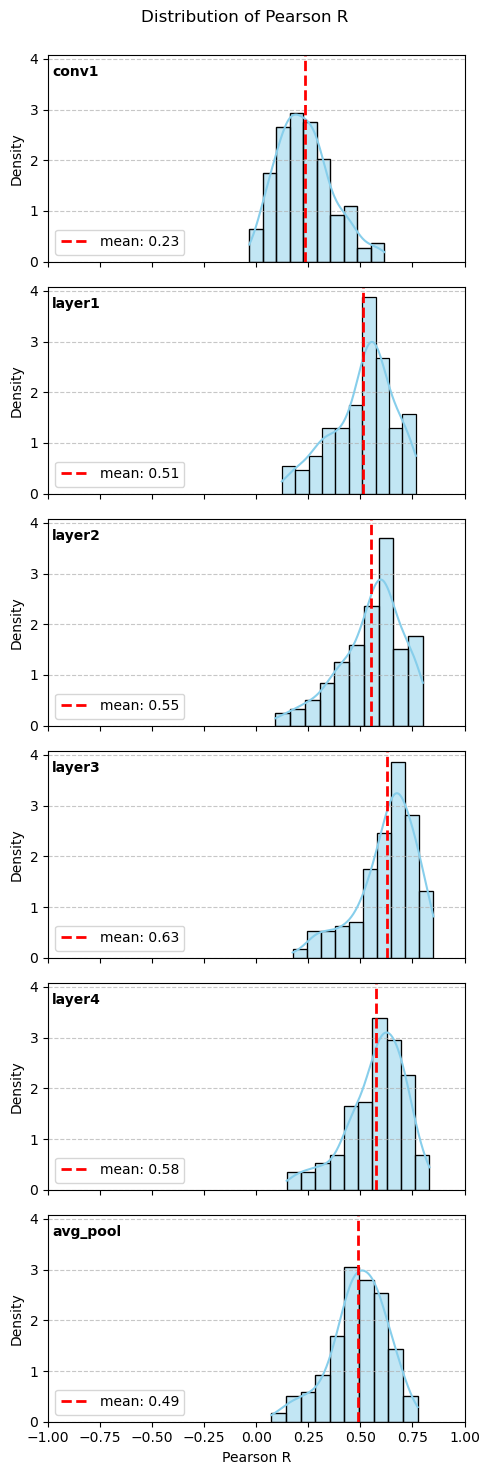

In [8]:
fig, axes = plt.subplots(len(hooked_layer_names),1, figsize=(5, 15),sharex=True,sharey=True)
axes = axes.flatten()

for ax,layer_name in zip(axes,hooked_layer_names):

    sns.histplot(lin_reg_results['corr'][layer_name],ax=ax, bins=10,kde=True, stat='density',color='skyblue')
    # ax.set_title(f'{layer_name}')
    ax.text(0.01, 0.95, layer_name, fontsize=10, fontweight='bold', ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel("Pearson R")
    ax.set_ylabel("Density")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlim([-1,1])
    ax.axvline(x=lin_reg_results['corr'][layer_name].mean(), color='red', linestyle='--', linewidth=2,label=f'mean: {lin_reg_results['corr'][layer_name].mean():0.2f}')
    ax.legend(loc='lower left')

plt.suptitle("Distribution of Pearson R")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

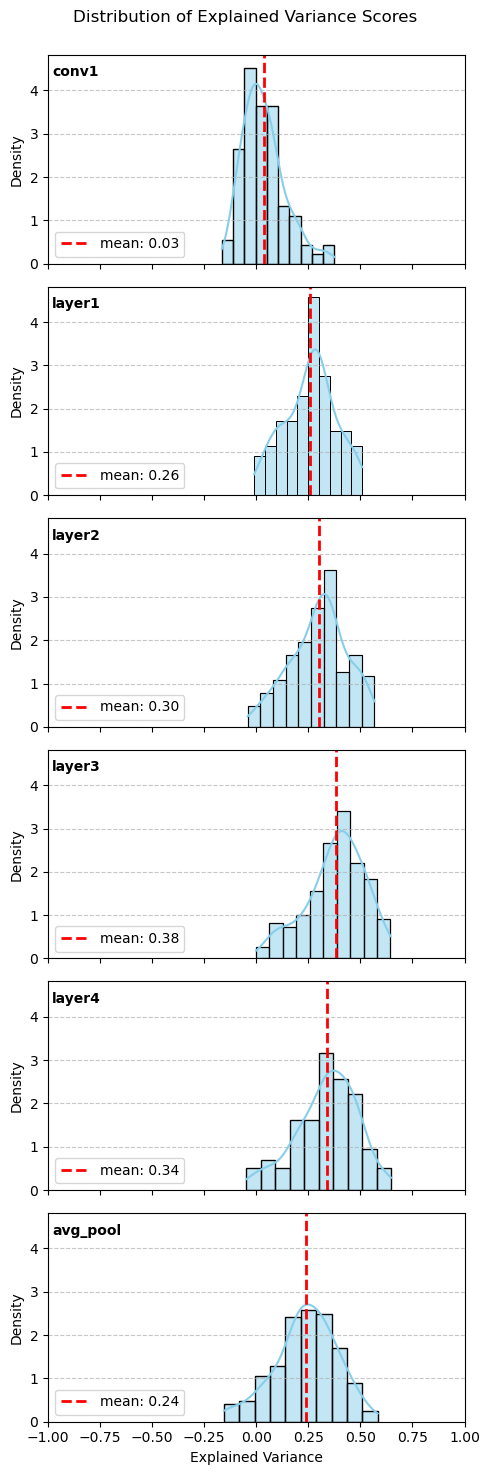

In [9]:
fig, axes = plt.subplots(len(hooked_layer_names),1, figsize=(5, 15),sharex=True,sharey=True)
axes = axes.flatten()

for ax,layer_name in zip(axes,hooked_layer_names):

    sns.histplot(lin_reg_results['EV'][layer_name],ax=ax, bins=10,kde=True, stat='density',color='skyblue')
    # ax.set_title(f'{layer_name}')
    ax.text(0.01, 0.95, layer_name, fontsize=10, fontweight='bold', ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel("Explained Variance")
    ax.set_ylabel("Density")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim([-1,1])
    ax.axvline(x=lin_reg_results['EV'][layer_name].mean(), color='red', linestyle='--', linewidth=2,label=f'mean: {lin_reg_results['EV'][layer_name].mean():0.2f}')
    ax.legend(loc='lower left')


plt.suptitle("Distribution of Explained Variance Scores")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Randomly-Initilized ResNet

In [10]:
hooked_layer_names = ['conv1','layer1','layer2','layer3','layer4','avg_pool']

pca_activations_train = np.load('pca_activations_random_train.npz')
pca_activations_val = np.load('pca_activations_random_val.npz')

lin_reg_results = {'corr':{},'EV':{},'MSE':{}}
for layer_name in tqdm(hooked_layer_names):
    X_train = pca_activations_train[layer_name]
    X_val = pca_activations_val[layer_name]

    y_train = spikes_train
    y_val = spikes_val

    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(solver='auto'))])

    param_grid = {
        'ridge__alpha': np.logspace(-3, 3, 6),
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    ridge_grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=cv.split(X_train,objects_train),
        n_jobs=-1
    )
    ridge_grid_search.fit(X_train, y_train)
    best_params = ridge_grid_search.best_params_
    best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_params['ridge__alpha']))])
    best_model.fit(X_train,y_train)

    y_pred = best_model.predict(X_val)
    lin_reg_results['MSE'][layer_name] = mean_squared_error(y_val, y_pred)
    lin_reg_results['corr'][layer_name] = pearsonr(y_val,y_pred).statistic
    lin_reg_results['EV'][layer_name] = explained_variance_score(y_val, y_pred, multioutput='raw_values')

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.05s/it]


In [11]:
rand_EV_layer_means = {layer_name:lin_reg_results['EV'][layer_name].mean() for layer_name in hooked_layer_names}
layer_with_highest_EV_mean = max(rand_EV_layer_means, key=rand_EV_layer_means.get)
sorted_EV_layer_means = sorted(rand_EV_layer_means.items(), key=lambda x: x[1], reverse=True)
for layer_name, ev_mean in sorted_EV_layer_means:
    print(f"Layer: {layer_name}, EV Mean: {ev_mean:.4f}")
print('-----')
rand_R_layer_means = {layer_name:lin_reg_results['corr'][layer_name].mean() for layer_name in hooked_layer_names}
sorted_R_layer_means = sorted(rand_R_layer_means.items(), key=lambda x: x[1], reverse=True)
for layer_name, R_mean in sorted_R_layer_means:
    print(f"Layer: {layer_name}, R Mean: {R_mean:.4f}")
print('-----') 
sorted_MSE_layer_means = sorted(lin_reg_results['MSE'].items(), key=lambda x: x[1], reverse=False)
for layer_name, MSE_mean in sorted_MSE_layer_means:
    print(f"Layer: {layer_name}, MSE Mean: {MSE_mean:.4f}")

Layer: layer2, EV Mean: 0.1861
Layer: layer1, EV Mean: 0.1652
Layer: layer3, EV Mean: 0.1625
Layer: layer4, EV Mean: 0.1427
Layer: avg_pool, EV Mean: 0.0227
Layer: conv1, EV Mean: 0.0130
-----
Layer: layer2, R Mean: 0.4192
Layer: layer1, R Mean: 0.3972
Layer: layer3, R Mean: 0.3939
Layer: layer4, R Mean: 0.3733
Layer: avg_pool, R Mean: 0.2897
Layer: conv1, R Mean: 0.2200
-----
Layer: layer2, MSE Mean: 0.1105
Layer: layer1, MSE Mean: 0.1133
Layer: layer3, MSE Mean: 0.1138
Layer: layer4, MSE Mean: 0.1164
Layer: avg_pool, MSE Mean: 0.1326
Layer: conv1, MSE Mean: 0.1368


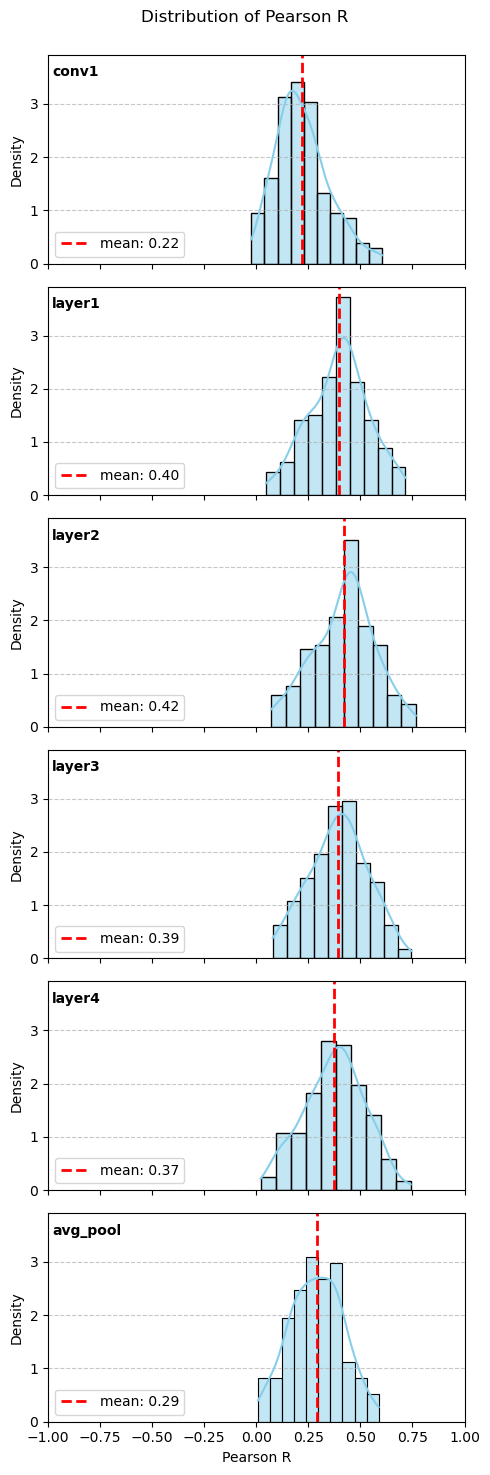

In [12]:
fig, axes = plt.subplots(len(hooked_layer_names),1, figsize=(5, 15),sharex=True,sharey=True)
axes = axes.flatten()

for ax,layer_name in zip(axes,hooked_layer_names):

    sns.histplot(lin_reg_results['corr'][layer_name],ax=ax, bins=10,kde=True, stat='density',color='skyblue')
    # ax.set_title(f'{layer_name}')
    ax.text(0.01, 0.95, layer_name, fontsize=10, fontweight='bold', ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel("Pearson R")
    ax.set_ylabel("Density")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlim([-1,1])
    ax.axvline(x=lin_reg_results['corr'][layer_name].mean(), color='red', linestyle='--', linewidth=2,label=f'mean: {lin_reg_results['corr'][layer_name].mean():0.2f}')
    ax.legend(loc='lower left')

plt.suptitle("Distribution of Pearson R")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

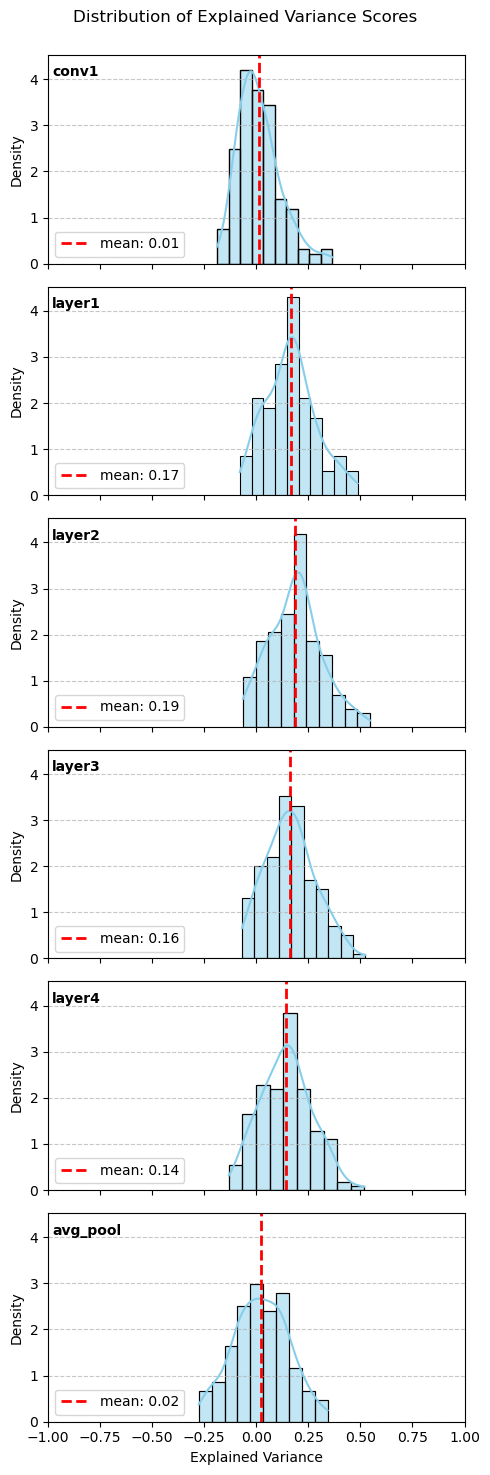

In [13]:
fig, axes = plt.subplots(len(hooked_layer_names),1, figsize=(5, 15),sharex=True,sharey=True)
axes = axes.flatten()

for ax,layer_name in zip(axes,hooked_layer_names):

    sns.histplot(lin_reg_results['EV'][layer_name],ax=ax, bins=10,kde=True, stat='density',color='skyblue')
    # ax.set_title(f'{layer_name}')
    ax.text(0.01, 0.95, layer_name, fontsize=10, fontweight='bold', ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel("Explained Variance")
    ax.set_ylabel("Density")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim([-1,1])
    ax.axvline(x=lin_reg_results['EV'][layer_name].mean(), color='red', linestyle='--', linewidth=2,label=f'mean: {lin_reg_results['EV'][layer_name].mean():0.2f}')
    ax.legend(loc='lower left')


plt.suptitle("Distribution of Explained Variance Scores")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Comparasion

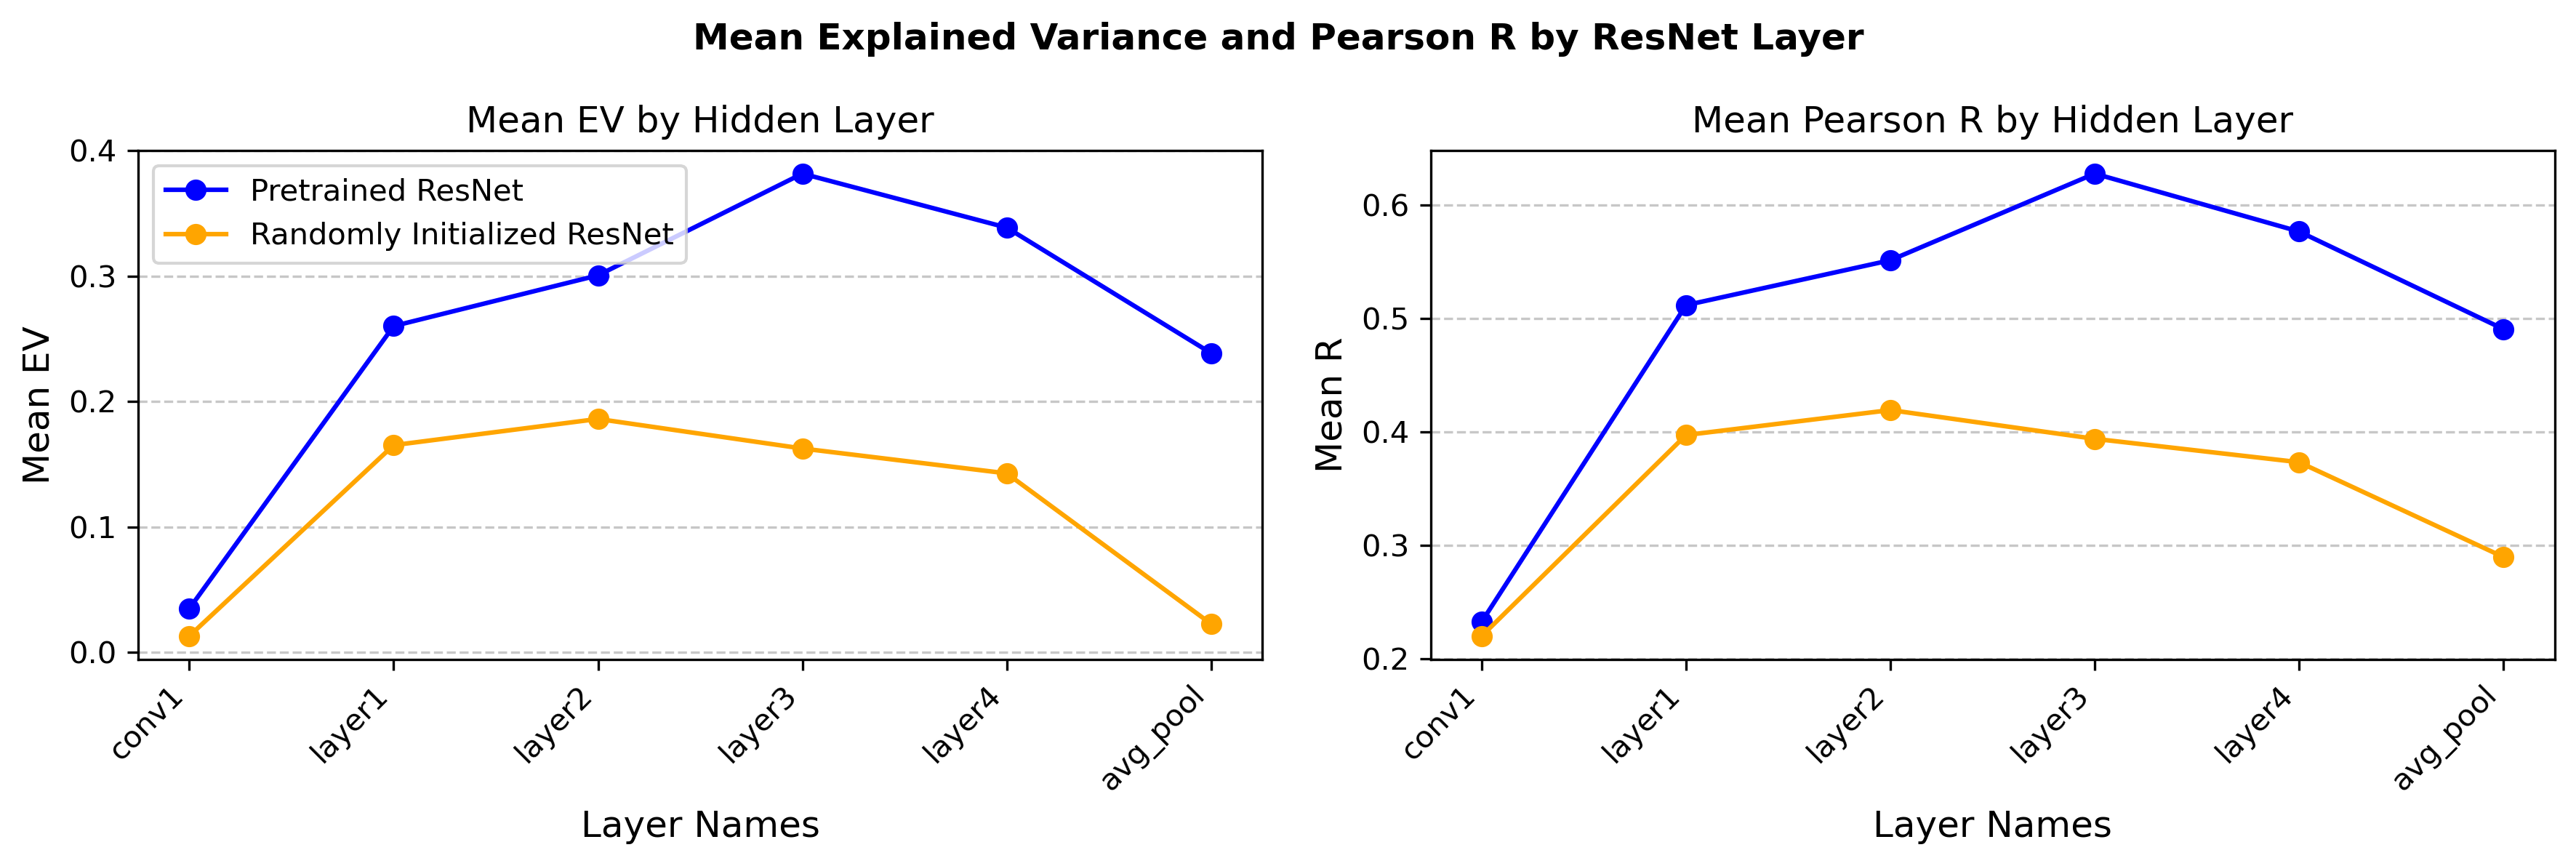

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
axes = axes.flatten()

# Mean EV
axes[0].plot(
    list(EV_layer_means.values()), 
    marker='o', linestyle='-', color='b', label="Pretrained ResNet"
)
axes[0].plot(
    list(rand_EV_layer_means.values()), 
    marker='o', linestyle='-', color='orange', label="Randomly Initialized ResNet"
)
axes[0].set_xticks(ticks=range(len(EV_layer_means)))
axes[0].set_xticklabels(list(EV_layer_means.keys()), rotation=45, ha='right')
axes[0].set_xlabel("Layer Names", fontsize=12)
axes[0].set_ylabel("Mean EV", fontsize=12)
axes[0].set_title("Mean EV by Hidden Layer")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(
    loc='upper left', 
    bbox_to_anchor=(0, 1), 
)

# Mean R
axes[1].plot(
    list(R_layer_means.values()), 
    marker='o', linestyle='-', color='b', label="Pretrained ResNet"
)
axes[1].plot(
    list(rand_R_layer_means.values()), 
    marker='o', linestyle='-', color='orange', label="Randomly Initialized ResNet"
)
axes[1].set_xticks(ticks=range(len(EV_layer_means)))
axes[1].set_xticklabels(list(EV_layer_means.keys()), rotation=45, ha='right')
axes[1].set_xlabel("Layer Names", fontsize=12)
axes[1].set_ylabel("Mean R", fontsize=12)
axes[1].set_title("Mean Pearson R by Hidden Layer")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Mean Explained Variance and Pearson R by ResNet Layer", fontweight='bold')
plt.tight_layout()
plt.show()